In [19]:
import numpy as np
import networkx as nx
import pandas
import matplotlib.pyplot as plt
import itertools
import scipy
import tqdm
import copy
import datetime

## Load data

In [42]:
dataset = "large"
datadir = "data/"
df = pandas.read_csv(datadir + dataset+".csv")
df[:5]

,N1,N2,N3,N4,N48,N6,N7,N14,N15,N17,...,N20,N22,N23,N30,N38,N26,N28,N50,N25,N35
0,2,1,1,1,1,2,2,1,1,4,...,2,1,1,2,1,2,3,1,1,2
1,3,2,2,1,2,3,3,1,1,1,...,2,2,2,1,1,2,2,2,3,1
2,2,2,1,1,2,3,1,1,2,4,...,1,4,3,2,3,2,1,1,1,2
3,2,2,1,1,2,2,3,4,2,1,...,2,4,1,3,3,1,1,1,2,1
4,2,2,1,1,2,2,1,4,2,1,...,3,3,4,3,2,2,1,2,2,2


In [43]:
column_names = list(df.columns)
data = np.array(df)
node_info = [(column_names[i], (np.min(data[:,i]), np.max(data[:,i]))) for i in range(data.shape[1])]
print(node_info)
print(len(node_info))

[('N1', (1, 3)), ('N2', (1, 2)), ('N3', (1, 2)), ('N4', (1, 2)), ('N48', (1, 2)), ('N6', (1, 4)), ('N7', (1, 3)), ('N14', (1, 4)), ('N15', (1, 2)), ('N17', (1, 4)), ('N49', (1, 3)), ('N33', (1, 2)), ('N10', (1, 4)), ('N34', (1, 4)), ('N11', (1, 4)), ('N16', (1, 3)), ('N27', (1, 4)), ('N19', (1, 4)), ('N31', (1, 3)), ('N32', (1, 4)), ('N40', (1, 4)), ('N5', (1, 3)), ('N12', (1, 2)), ('N41', (1, 2)), ('N47', (1, 3)), ('N8', (1, 2)), ('N9', (1, 3)), ('N13', (1, 3)), ('N24', (1, 4)), ('N21', (1, 3)), ('N37', (1, 4)), ('N44', (1, 2)), ('N45', (1, 2)), ('N39', (1, 3)), ('N18', (1, 4)), ('N46', (1, 2)), ('N29', (1, 4)), ('N36', (1, 3)), ('N43', (1, 3)), ('N42', (1, 2)), ('N20', (1, 3)), ('N22', (1, 4)), ('N23', (1, 4)), ('N30', (1, 3)), ('N38', (1, 4)), ('N26', (1, 3)), ('N28', (1, 3)), ('N50', (1, 2)), ('N25', (1, 3)), ('N35', (1, 4))]
50


## BayesNet Datastructure

In [44]:
class BayesNet:
    
    def __init__(self, graph, node_info, adjacency_matrix=None):
        if adjacency_matrix is not None:
            self.adjacency_matrix = adjacency_matrix
            self.G = nx.convert_matrix.from_numpy_array(self.adjacency_matrix, create_using=nx.DiGraph())
        else:
            self.G = graph
        
        if self.is_dag:
            self.node_info = node_info
            self.node_names = [info[0] for info in self.node_info]
            self.n_nodes = len(self.node_info)

            self.vals_per_node = [vals[1] for name, vals in node_info]
            self.node_values = [np.arange(vals[0], vals[1] + 1) for name, vals in node_info]
            self.parent_sets = [list(self.G.predecessors(i)) for i in self.G.nodes]

            n_parental_instances = [np.prod([self.vals_per_node[p] for p in parents]) for parents in self.parent_sets]
            m_matrices = [np.zeros((int(npis), int(vals))) for npis, vals in zip(n_parental_instances, self.vals_per_node)]

            self.ms = m_matrices
    
    def count_ms(self, data):
        for i in range(self.n_nodes):
            parents = self.parent_sets[i]
            n_parents = len(parents)
            if n_parents > 0:
                parental_instantiations = itertools.product(*[self.node_values[p] for p in parents])
                for j, pi in enumerate(parental_instantiations):
                    mask = data[:,parents[0]] == pi[0]
                    for k in range(1,n_parents):
                        mask = np.logical_and(mask, data[:,parents[k]] == pi[k])
                    pi_data = data[mask,i]
                    vals, counts = np.unique(pi_data, return_counts=True)
                    self.update_counts(i, j, vals, counts)
            else:
                vals, counts = np.unique(data[:,i], return_counts=True)
                self.update_counts(i, 0, vals, counts)
    
    def update_counts(self, node, pi, vals, counts):
        for v, c in zip(vals, counts):
            self.ms[node][pi, v - 1] += c
    
    @property
    def is_dag(self):
        return nx.is_directed_acyclic_graph(self.G)
    
    def draw(self, k=None):
        nx.draw(self.G, labels={i:info[0] for i, info in enumerate(self.node_info)}, k=k)
        
    def save(self, filename):
        with open(filename, 'w') as f:
            for edge in self.G.edges():
                f.write("{}, {}\n".format(self.node_names[edge[0]], self.node_names[edge[1]]))
        

In [45]:
def get_dag(p):
    no_dag = True
    while no_dag:    
        A = np.random.binomial(1, p, size=[len(node_info)] * 2)
        np.fill_diagonal(A, 0)
        g = BayesNet(None, node_info, adjacency_matrix=A)
        no_dag = not g.is_dag
    return g



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


 15%|████████████▍                                                                      | 3/20 [00:00<00:01, 15.26it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 32.81it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 39.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 37.58it/s]

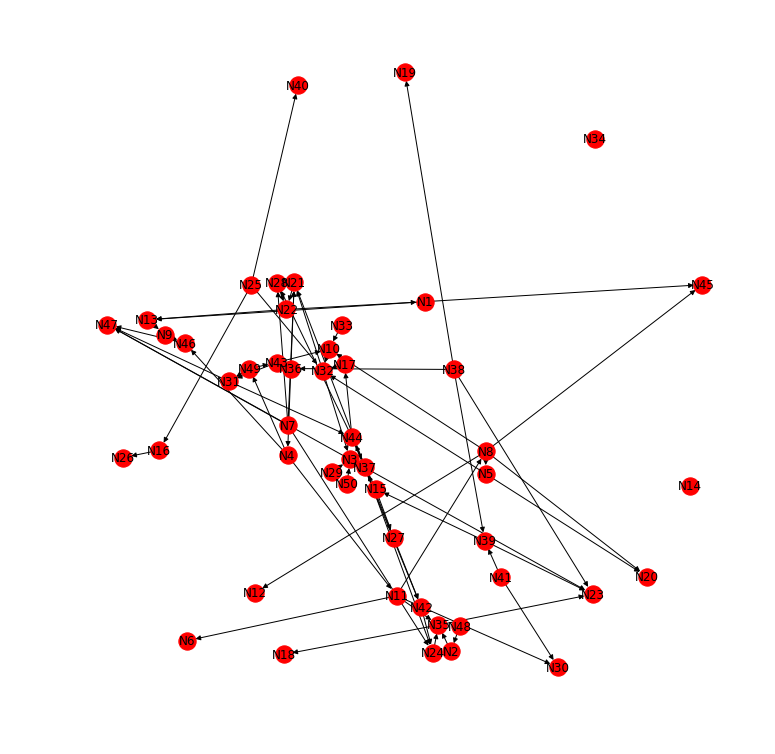

In [47]:
n_dags = 20
p = 0.03
dags = [get_dag(p) for _ in tqdm.tqdm(range(n_dags))]
g = dags[0]
plt.figure(figsize=(10,10))
g.draw(k=100)

In [48]:
for g in dags:
    g.count_ms(data)

In [49]:
scipy.special.loggamma(1)

0.0

## Compute Bayesian Score

In [50]:
def bay_score_node(m):
    p = np.sum(scipy.special.loggamma(m + 1))
    p += m.shape[0] * scipy.special.loggamma(m.shape[1])
    p -= np.sum(scipy.special.loggamma(m.shape[1] + np.sum(m, axis=1)))
    return p
    
def compute_bayesian_score(g):
    return np.sum([bay_score_node(m) for m in g.ms])

In [51]:
scores = [compute_bayesian_score(g) for g in dags]

In [52]:
gmin = dags[np.argmin(scores)]
gmax = dags[np.argmax(scores)]

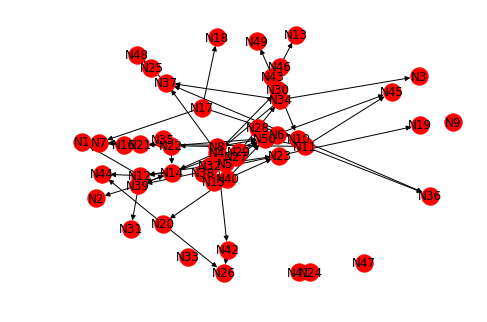

In [53]:
gmin.draw()

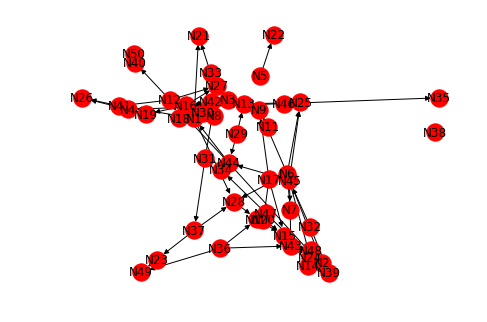

In [54]:
gmax.draw()

## Random Search

In [60]:
hyperparams = {"p_add":.5, "max_parents":7}

def num_parents(g, n):
    parents = list(g.predecessors(n))
    return len(parents)

def generate_neighbor(g):
    graph = copy.deepcopy(g.G)
    add_edge = np.random.binomial(1,hyperparams["p_add"])
    modified = False
    if add_edge or len(graph.edges) == 0:
        edges = list(nx.non_edges(graph))
        np.random.shuffle(edges)
        for edge in edges:
            if not nx.has_path(graph, edge[1], edge[0]) and num_parents(graph, edge[1]) < hyperparams["max_parents"]:
                graph.add_edge(*edge)
                net = BayesNet(graph, node_info)
                net.count_ms(data)
                modified = True
                break
    if not add_edge or not modified:
        edges = list(nx.edges(graph))
        l = len(edges)
        edge = edges[np.random.randint(l)]
        graph.remove_edge(*edge)
        net = BayesNet(graph, node_info)
        net.count_ms(data)
    return net

In [61]:
def simulated_annealing(initial_candidate, T=1000, epochs=1):
    best_solution = initial_candidate
    best_solution_cost = compute_bayesian_score(initial_candidate)
    
    costs = [best_solution_cost]
    # the best solution we had so far
    
    all_time_best_solution = initial_candidate
    all_time_best_cost = best_solution_cost
    
    while (T > 0):
        print(T)
        for epoch in range(epochs):
            candidate = generate_neighbor(best_solution)
            candidate_cost = compute_bayesian_score(candidate)
            cost_change = candidate_cost - best_solution_cost  # we want to accept higher cost
            if (cost_change > 0):
                # move to candidate state
                best_solution = candidate
                best_solution_cost = candidate_cost
                costs.append(best_solution_cost)
            elif (np.exp(cost_change / (T)) > np.random.uniform()):
                # move to candidate state
                best_solution = candidate
                best_solution_cost = candidate_cost
                costs.append(best_solution_cost)
            if all_time_best_cost < candidate_cost:
                all_time_best_solution = candidate
                all_time_best_cost = candidate_cost
        T -= 1
    return all_time_best_solution, all_time_best_cost, costs


## Run simulated annealing

In [62]:
t0 = datetime.datetime.now()
best_solution, best_cost, costs = simulated_annealing(gmax, T=1000, epochs=2)
print(datetime.datetime.now() - t0)

1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751

-482542.5843598574


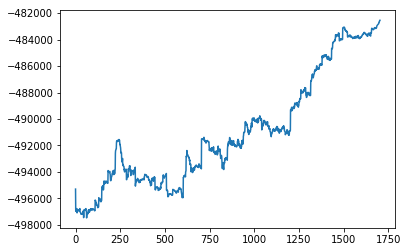

In [63]:
plt.plot(costs)
print(best_cost)

True


-3854.395569359951

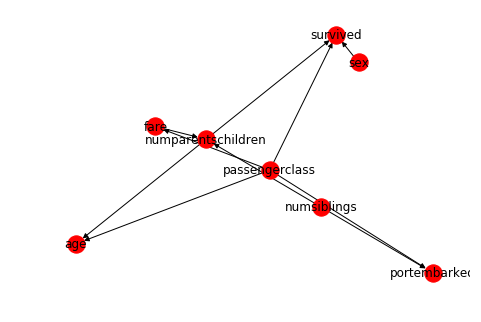

In [24]:
best_solution.draw(k=200)
print(best_solution.is_dag)
compute_bayesian_score(best_solution)

## Store results

In [293]:
outdir = "test_outputs5/"
best_solution.save(outdir + dataset + ".gph")

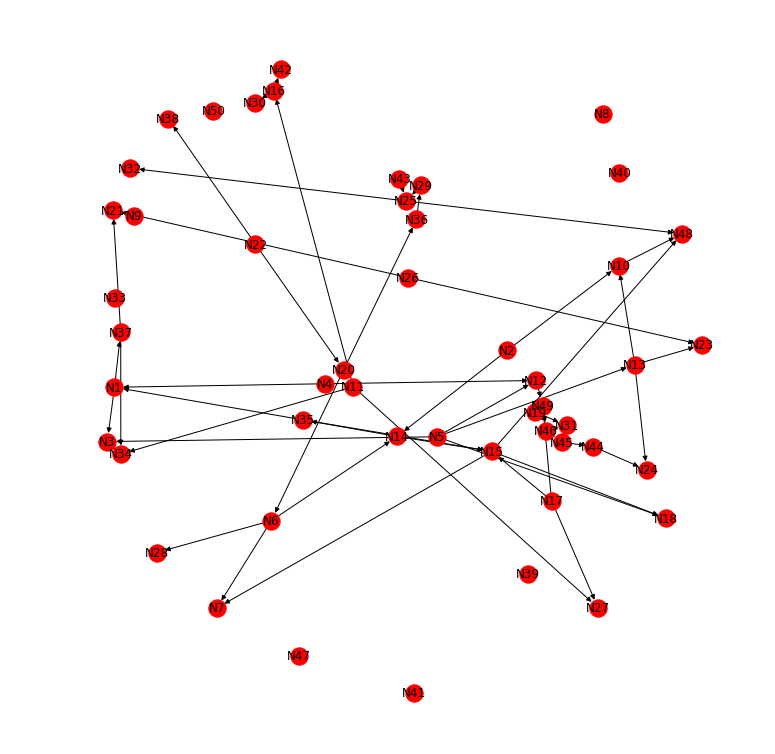

In [308]:
plt.figure(figsize=(10,10))
best_solution.draw(k=5)
plt.savefig(outdir + dataset + ".png")

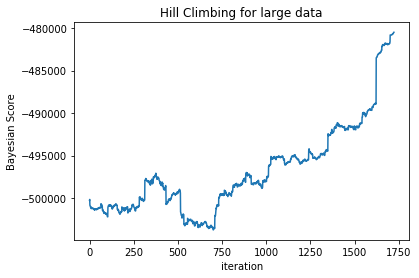

In [309]:
plt.plot(costs)
plt.xlabel("iteration")
plt.ylabel("Bayesian Score")
plt.title("Hill Climbing for " + dataset + " data")
plt.savefig(outdir + dataset + "_cost.png")

In [64]:
print(best_solution.parent_sets)
print("")
print(best_solution.node_values)

[[3, 4, 7], [0, 7, 4, 2], [], [4, 2], [2], [2, 4, 7, 3, 6], [0, 2, 7, 3], [2, 4, 3]]

[array([1, 2, 3], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2], dtype=int64), array([1, 2, 3], dtype=int64), array([1, 2], dtype=int64)]


In [37]:
node = 1
best_solution.ms[1].shape
pis = itertools.product(best_solution.node_values[0], best_solution.node_values[6])
m = np.zeros((9,3))
for j,pi in enumerate(pis):
    for d in data:
        if d[0] == pi[0] and d[6] == pi[1]:
            m[j, d[1] - 1] += 1

In [41]:
np.sum(m)

889.0

In [40]:
np.sum(best_solution.ms[1])

889.0

In [165]:
np.exp(-4/1)

0.01831563888873418

In [ ]:
G = nx.DiGraph()
G.add_edge(1,2)
G.add_edge(3,4)
G.add_edge(4,1)
nx.draw(G, labels={i+1:str(i + 1) for i in range(4)})

In [46]:
A = nx.to_numpy_array(G)

In [68]:
parents = [G.predecessors(node) for node in G.nodes]


[4]

In [42]:
X = np.zeros((3,3))
X[1,0] = 1
X[1,1] = 1
X[1,2] = 1
X[0,0] = 1
X[0,1] = 1

In [44]:
mask = np.logical_and(X[:,0] == 1, X[:,1] == 1)
X[mask,-1]

array([0., 1.])

In [38]:
A[mask]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 3

In [49]:
for j in itertools.product((), ()):
    print("hi")

In [51]:
a = np.array([1,1,2,3,4,6,7,3,3])
np.unique(a, return_counts=True)

(array([1, 2, 3, 4, 6, 7]), array([2, 1, 3, 1, 1, 1], dtype=int64))

In [90]:
A = np.zeros((8,8))
# A[0,1] = 1
# A[2,3] = 1
# A[4,5] = 1
g = BayesNet(A, node_info)
g.count_ms(data)
compute_bayesian_score(g.ms)

-4166.225858784904

In [83]:
g.ms

[array([[0., 0., 0.]]), array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), array([[0., 0., 0.]]), array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), array([[0., 0., 0.]]), array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])]

In [84]:
g.parent_sets

[[], [0], [], [2], [], [4]]

In [92]:
nx.convert_matrix.to_numpy_array(g.G)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [30]:
np.random.shuffle(list(g.G.edges))

OutEdgeView([(0, 1), (0, 2), (0, 7), (1, 3), (3, 5), (3, 6), (4, 2), (4, 7), (5, 2), (6, 5), (7, 6)])

In [49]:
vals = np.random.binomial(1,.1, size = 1000)
np.mean(vals)

0.107

In [82]:
gmax.G.edges

OutEdgeView([(0, 4), (0, 7), (2, 3), (5, 4), (5, 6), (5, 7), (6, 1), (6, 2), (7, 1), (7, 2)])